In [3]:
import json
import time
from pyspark.sql import SparkSession

In [4]:
# instantiate a spark session
spark = SparkSession.builder.appName('Demo').getOrCreate()

In [5]:
from pyspark.sql import functions as F

In [6]:
spark

## RDD

In [8]:
sc = spark.sparkContext

In [97]:
sc.parallelize(range(100000000))

PythonRDD[98] at RDD at PythonRDD.scala:49

In [94]:
r1 = sc.parallelize([1, 2, 3])

In [95]:
r1

ParallelCollectionRDD[94] at parallelize at PythonRDD.scala:184

In [98]:
r1.first()

1

In [99]:
r1.take(2)

[1, 2]

In [100]:
r1.collect()

[1, 2, 3]

In [101]:
r1.count()

3

In [102]:
r1.sum()

6

In [43]:
r2 = sc.parallelize(range(1000))

In [104]:
r2.map(lambda x: x**2).take(10)

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

In [45]:
def is_prime(n):
    for i in range(2,int(n**0.5)+1):
        if n%i==0:
            return False
    return True

In [106]:
r2.filter(lambda x: is_prime(x))

PythonRDD[108] at RDD at PythonRDD.scala:49

In [46]:
prime_squares = r2.filter(is_prime).map(lambda x: x**2)

In [112]:
r2.filter(is_prime).map(lambda x: x**2).fiter()

PythonRDD[112] at RDD at PythonRDD.scala:49

In [110]:
r2.take(3)

[0, 1, 2]

In [9]:
r2.getNumPartitions()

8

In [ ]:
sc.parallelize([[1, 2], [4, 3]])

In [ ]:
sc.parallelize([1, 2, 3]).mapValues(len).collect()

In [19]:
sc.parallelize([1, 2, 3]).flatMap(lambda x: x)

#### Spark's basic abstraction is an **RDD**.
 1. RDDs are fault-tolerant, parallel data structures
 2. Allow coarse-grained transformations in contrast to array or database => logging transformations (lineage) yields fault tolerance
 3. RDD is a read-only, partitioned collection of records (immutable)

#### Two kinds of operations:
1. **Transformations** are lazy: _map_, _filter_, and _join_ => (can combine multiple mappers)
2. **Actions** are eager: _count_, _collect_, _save_, _take_, _saveAsTextFile_

#### Representation of RDDs / The RDD Interface
 - Set of _partitions_
 - Dependencies on parent RDDs
 - Function to compute a partition given parents

#### Details
 * **Narrow** and **wide** transformations: **Wide** transformation requires shuffling across partitions.
 * RDDs are cacheable
 * Spark job is a **DAG of RDDs**. (Hence no need of intermediate data materialization)
 * Task is data + computation. (1 partition, 1 thread)
 * When you create the SparkContext, each worker starts an executor. This is a separate process (JVM), and it loads your jar too. The executors connect back to your driver program.

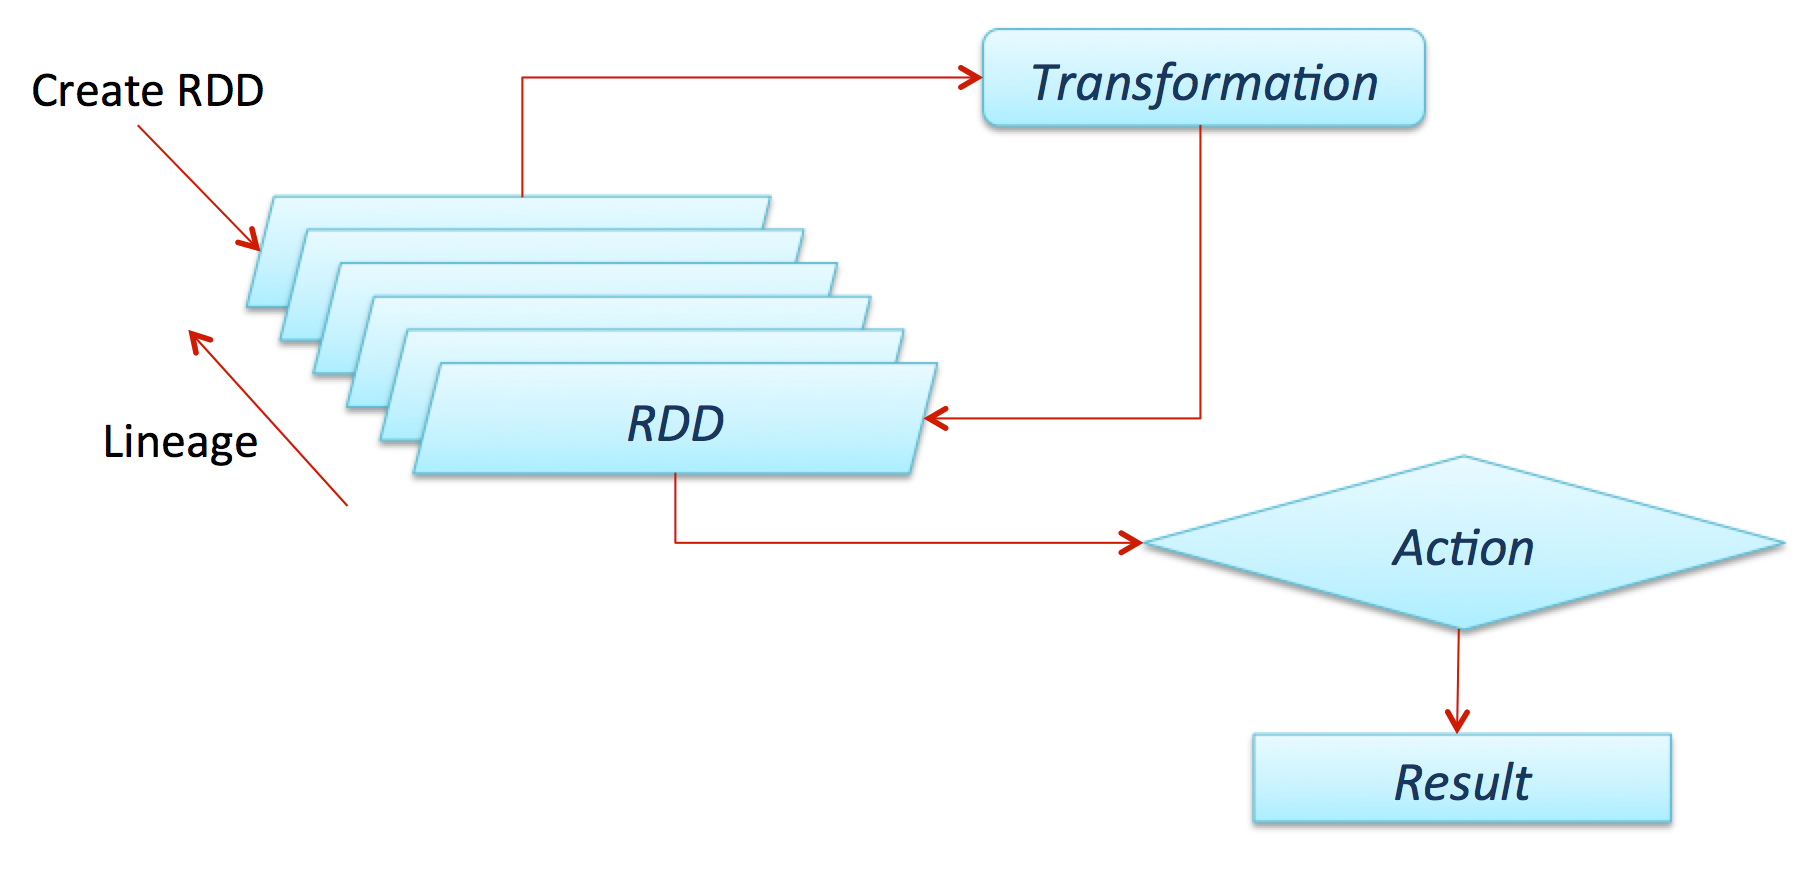

![rdd_lineage.png](assets/rdd_lineage.png)


#### [Official Docs](https://spark.apache.org/docs/latest/api/python/index.html)

## Word Count

In [21]:
tales = sc.textFile('/Users/300041370/data/shakespeare_tales.txt')

In [22]:
tales.take(10)

["Project Gutenberg's Tales from Shakespeare, by Charles Lamb and Mary  Lamb",
 '',
 'This eBook is for the use of anyone anywhere at no cost and with',
 'almost no restrictions whatsoever.  You may copy it, give it away or',
 're-use it under the terms of the Project Gutenberg License included',
 'with this eBook or online at www.gutenberg.org',
 '',
 '',
 'Title: Tales from Shakespeare',
 '']

In [122]:
sc.parallelize([{1:2}, {2:3}]).map(lambda x: list(x.items())).collect()

[[(1, 2)], [(2, 3)]]

In [120]:
tales.map(lambda line: line.split(' ')[:3]).take(3)

[['Project', "Gutenberg's", 'Tales'], [''], ['This', 'eBook', 'is']]

If a function `func` undergoes **map** transformation `RDD[str]` to `RDD[List[str]]`, then
**flatMap** transformation takes `RDD[str]` to `RDD[str]`. It basically _flattens_ the mapped RDD

**map**: 1 to 1

**flatMap**: 1 to many

In [118]:
def flatten(ls):
	return [item for sublist in ls for item in sublist]

flatten([[1, 2], [3, 4], [5, 6]])

[1, 2, 3, 4, 5, 6]

In [119]:
tales

/Users/300041370/data/shakespeare_tales.txt MapPartitionsRDD[118] at textFile at NativeMethodAccessorImpl.java:0

In [123]:
tales.flatMap(lambda line: line.split(' ')).take(10)

['Project',
 "Gutenberg's",
 'Tales',
 'from',
 'Shakespeare,',
 'by',
 'Charles',
 'Lamb',
 'and',
 'Mary']

In [23]:
words = tales.flatMap(lambda line: line.split(' '))

In [22]:
words

PythonRDD[16] at RDD at PythonRDD.scala:49

### Method 1: `countByValue`

In [1]:
words.countByValue()

### More general method
**`groupByKey`**

In [128]:
words.map(lambda word: (word, 1)).groupByKey().map(lambda x: (x[0], len(x[1]))).take(3)

[('Project', 78), ('Tales', 7), ('Lamb', 6)]

In [130]:
words.map(lambda word: (word, 1)).groupByKey().mapValues(len).take(5)

[('Project', 78), ('Tales', 7), ('Lamb', 6), ('Mary', 3), ('', 2609)]

### Better & General method

In [132]:
counts = words.map(lambda x: (x, 1)).reduceByKey(lambda c1, c2: c1+c2).collect()

In [133]:
sorted(counts, key=lambda x: x[1], reverse=True)[:10]

[('the', 4960),
 ('and', 3774),
 ('to', 3577),
 ('of', 2983),
 ('', 2609),
 ('he', 1921),
 ('a', 1875),
 ('his', 1833),
 ('in', 1476),
 ('was', 1450)]

In [24]:
word_counts = words.map(lambda x: (x, 1)).reduceByKey(lambda c1, c2: c1+c2)

In [25]:
word_counts.sortBy(lambda x: x[1], False).take(5)

[('the', 4960), ('and', 3774), ('to', 3577), ('of', 2983), ('', 2609)]

`reduceByKey` works like MapReduce's **_combiner_** (also called semi-reducer)

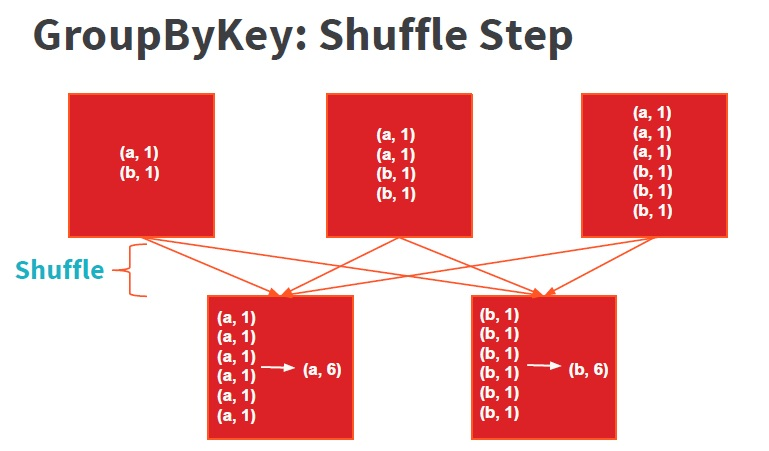

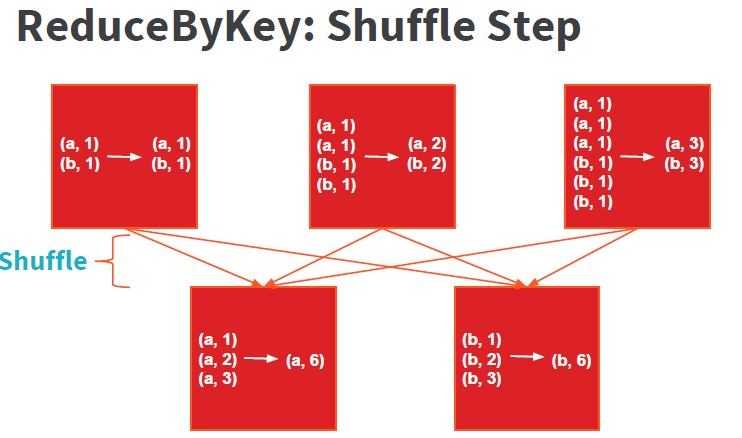

### Cache

If multiple actions are called on an RDD, it will be executed repeatedly. Hence, there is option to persist the RDD's value - in memory and disk. Caching follows LRU policy to evict.

In [4]:
def is_prime(n):
    for i in range(2,int(n**0.5)+1):
        if n%i==0:
            return False
    return True

In [7]:
natural = sc.parallelize(range(int(1e6)))
primes = natural.filter(is_prime)

In [19]:
primes.count()

78500

In [10]:
primes.cache() # keep primes in-memory

PythonRDD[3] at RDD at PythonRDD.scala:49

In [17]:
primes.unpersist() # flush primes

PythonRDD[3] at RDD at PythonRDD.scala:49

### Specialized tool beats a general purpose tool
Specialized tools usually outperform or are more accurate than general purpose tools ([Hettinger](https://twitter.com/raymondh/status/974018651308179456))
 - `math.sqrt(x)` is more accurate than `x ** 0.5`
 - `math.log2()` is exact for powers of two
    ```python
    from math import log, log2
    all(log(2 ** x, 2) == x for x in range(100)) # False
    all(log2(2 ** x) == x for x in range(100)) # True
    ```
 - In Spark, `countByKey()` is way faster than using `groupBy()` because of less shuffling involved.

Posit: Use `reduceByKey` instead of `groupByKey` if aggregation is commutative and associative. Partial aggregation reduces data movement. (Also, know the standard library)

[Spark's countByKey implementation](https://github.com/apache/spark/blob/master/core/src/main/scala/org/apache/spark/rdd/PairRDDFunctions.scala#L370)

## RDDs on uStream

In [11]:
rdd = sc.textFile('/Users/300041370/data/sample_ustream.gz') # local
rdd_s3 = sc.textFile('s3n://myntra-datasciences/uStream/2019/07/10/user_summary/*.gz') # s3

In [13]:
rdd_s3.take(1)

In [14]:
rdd.take(1)

['0010a7d5.776b.4621.8517.614feff5edf0FHkLlICZ5E\t{"login":"gorurai1731@gmail.com","uidx":"0010a7d5.776b.4621.8517.614feff5edf0FHkLlICZ5E","deviceId":"","installationId":"","customerProfile":{"firstName":"Gurpreet","lastName":"","dob":null,"gender":"m","firstLoginDate":1474716780000,"active":1,"verified":1,"userType":"regular","appId":1,"channel":"email","platform":"","device":"","profileInfoId":"30703094","createdBy":"erpMessageQueue","createdOn":1474716799000,"lastModifiedTime":1474716799000},"visitSummary":[{"visitStartTimestamp":1474696999618,"userAgent":"Mozilla/5.0 (Linux; Android 5.1.1; Redmi Note 3 Build/LMY47V; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/53.0.2785.124 Mobile Safari/537.36; MyntraRetailAndroid/3.8.1 (Phone, 480dpi); MyntraAndroid/3.8.1 (Phone, 480dpi); api;","uuid":"c963dd4a945c959c","deviceData":{"appVersion":null,"osFamily":null,"osVersion":null,"height":null,"width":null,"deviceManufacturer":null,"deviceModelNo":null,"deviceYear":null,"mobi

**uStream**: Every line is lifetime data for a user. It's a tab-separated string comprising 2 values: _uidx_ & json of lifetime activity

In [16]:
rdd.map(lambda x: x.split('\t')[1]).take(1)

['{"login":"gorurai1731@gmail.com","uidx":"0010a7d5.776b.4621.8517.614feff5edf0FHkLlICZ5E","deviceId":"","installationId":"","customerProfile":{"firstName":"Gurpreet","lastName":"","dob":null,"gender":"m","firstLoginDate":1474716780000,"active":1,"verified":1,"userType":"regular","appId":1,"channel":"email","platform":"","device":"","profileInfoId":"30703094","createdBy":"erpMessageQueue","createdOn":1474716799000,"lastModifiedTime":1474716799000},"visitSummary":[{"visitStartTimestamp":1474696999618,"userAgent":"Mozilla/5.0 (Linux; Android 5.1.1; Redmi Note 3 Build/LMY47V; wv) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/53.0.2785.124 Mobile Safari/537.36; MyntraRetailAndroid/3.8.1 (Phone, 480dpi); MyntraAndroid/3.8.1 (Phone, 480dpi); api;","uuid":"c963dd4a945c959c","deviceData":{"appVersion":null,"osFamily":null,"osVersion":null,"height":null,"width":null,"deviceManufacturer":null,"deviceModelNo":null,"deviceYear":null,"mobileCarrier":null,"networkType":null,"bandwidth":n

In [48]:
rdd.map(lambda row: tuple(row.split('\t'))).map(lambda x: (x[0], json.loads(x[1])))

PythonRDD[45] at RDD at PythonRDD.scala:49

In [49]:
rdd.map(lambda row: tuple(row.split('\t'))).mapValues(lambda x: json.loads(x))

PythonRDD[46] at RDD at PythonRDD.scala:49

In [17]:
rdd.map(lambda row: tuple(row.split('\t'))).mapValues(json.loads)

PythonRDD[12] at RDD at PythonRDD.scala:49

`lambda x: func(x)` is same as `func`

In [22]:
ustream_data = rdd.map(lambda row: tuple(row.split('\t'))).mapValues(json.loads)

In [18]:
ustream_data.take(1)

In [23]:
def get_search_queries(ustream_dict):
	'''Returns the 'listPage' field'''
	
	queries = set() # consider same queries by a user only once
	for visit in ustream_dict['visitSummary']:
		for event in visit['listEvents']:
			query = event['listPage']
			normalized_query = ' '.join(query.lower().split())
			if event['queriedByUser']:
				queries.add(normalized_query)
	
	return list(queries)

In [24]:
ustream_data.mapValues(get_search_queries).take(5)

[('0010a7d5.776b.4621.8517.614feff5edf0FHkLlICZ5E', []),
 ('001e19de.f2e9.4cfc.8803.dd4476537cfbd1GV8dNYsH', []),
 ('00269bd9.3c52.4d25.9191.86a80612a416NhSvs2i61e',
  ['the shirt of ucb',
   'united colors of benetton',
   'nike flip flops',
   'nike men flip flops',
   'belle fille women',
   'the shirt of ucb t shirt']),
 ('0033dda2.5e64.4514.9c4d.8189a88989f8EZA7764LMZ',
  ['adidas shoes for men', 'checks shirts for kids', 'checks shirts for men']),
 ('005664db.0f37.4fe6.95f6.7b74a6543119S86b5iGnrU', [])]

In [25]:
ustream_data.map(lambda x: x[1]).map(get_search_queries).take(5)

[[],
 [],
 ['the shirt of ucb',
  'united colors of benetton',
  'nike flip flops',
  'nike men flip flops',
  'belle fille women',
  'the shirt of ucb t shirt'],
 ['adidas shoes for men', 'checks shirts for kids', 'checks shirts for men'],
 []]

In [26]:
ustream_data.map(lambda x: x[1]).flatMap(get_search_queries).take(10)

['the shirt of ucb',
 'united colors of benetton',
 'nike flip flops',
 'nike men flip flops',
 'belle fille women',
 'the shirt of ucb t shirt',
 'adidas shoes for men',
 'checks shirts for kids',
 'checks shirts for men',
 'nike air max infurate low basketball shoes']

In [27]:
queries = ustream_data.map(lambda x: x[1]).flatMap(get_search_queries)

In [28]:
queries

PythonRDD[16] at RDD at PythonRDD.scala:49

Visit <localhost:4040>

In [29]:
queries.map(lambda x: (x, 1)).groupByKey().mapValues(sum).take(5)

[('the shirt of ucb', 1),
 ('united colors of benetton', 34),
 ('nike flip flops', 38),
 ('nike men flip flops', 9),
 ('belle fille women', 2)]

In [30]:
queries.map(lambda x: (x, 1)).reduceByKey(lambda x, y: x + y).take(5)

[('the shirt of ucb', 1),
 ('united colors of benetton', 34),
 ('nike flip flops', 38),
 ('nike men flip flops', 9),
 ('belle fille women', 2)]

#### MapReduce and Spark
 - MapReduce doesn't modify input and doesn't have side effects. No of map tasks = no of input file blocks.
 - Mapper JAR is copied to all machines (**_putting computation near the data_**).
 - The process of partitioning by reducer, sorting, and copying data partitions from mappers to reducers is known as the _shuffle_ (_collate_). Hence, it's actually, *map-shuffle-reduce*.
 
**_The problem with MapReduce_** is that for multi-job complex workflows, we need to [materialize intermediate state](https://ap-southeast-1.console.aws.amazon.com/elasticmapreduce/home?region=ap-southeast-1#cluster-details:j-VZW1Z65C0W3M), i.e., we need to write output of one job in a distributed filesystem to input it to another job.
___

### Avg House Prices

How to find average?

In [31]:
house_prices = sc.textFile('/Users/300041370/data/house-prices.txt')

In [32]:
prices = house_prices.map(lambda x: (int(x.split(',')[1]), int(x.split(',')[0])))

In [33]:
prices.take(5)

[(2, 114300), (4, 114200), (3, 114800), (3, 94700), (3, 119800)]

In [34]:
prices_summed = prices.mapValues(lambda price: (price, 1))\
                .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))

In [35]:
prices_summed.mapValues(lambda x: x[0]//x[1]).sortByKey().collect()

[(2, 115260), (3, 125732), (4, 154265), (5, 169550)]

#### Can we find _median_ house price in this fashion?

### Spark DataFrame 
 * A fusion of Spark RDD and Pandas DataFrame. (RDD with schema or named columns)
 * Can be read from _json_, _parquet_, _jdbc_, _orc_, _csv_
 * MLlib & Structured Streaming are based on DataFrame
 * Works best on flat datasets

In [37]:
house_df = spark.read.csv('/Users/300041370/data/house-prices.csv', inferSchema=True, header=True)

In [38]:
house_df.printSchema()

root
 |-- Home: integer (nullable = true)
 |-- Price: integer (nullable = true)
 |-- SqFt: integer (nullable = true)
 |-- Bedrooms: integer (nullable = true)
 |-- Bathrooms: integer (nullable = true)
 |-- Offers: integer (nullable = true)
 |-- Brick: string (nullable = true)
 |-- Neighborhood: string (nullable = true)



In [39]:
house_df.show(10)

+----+------+----+--------+---------+------+-----+------------+
|Home| Price|SqFt|Bedrooms|Bathrooms|Offers|Brick|Neighborhood|
+----+------+----+--------+---------+------+-----+------------+
|   1|114300|1790|       2|        2|     2|   No|        East|
|   2|114200|2030|       4|        2|     3|   No|        East|
|   3|114800|1740|       3|        2|     1|   No|        East|
|   4| 94700|1980|       3|        2|     3|   No|        East|
|   5|119800|2130|       3|        3|     3|   No|        East|
|   6|114600|1780|       3|        2|     2|   No|       North|
|   7|151600|1830|       3|        3|     3|  Yes|        West|
|   8|150700|2160|       4|        2|     2|   No|        West|
|   9|119200|2110|       4|        2|     3|   No|        East|
|  10|104000|1730|       3|        3|     3|   No|        East|
+----+------+----+--------+---------+------+-----+------------+
only showing top 10 rows



In [30]:
house_df.approxQuantile(col='Price', probabilities=[0.5], relativeError=0.001)

[125700.0]

Based on Greenwald-Khanna algorithm.

$ (p-\epsilon)*N <= rank(x) <= (p+\epsilon)*N $

Spark implements other approximate algorithms too: HyperLogLog, LSH!

In [59]:
house_df.orderBy('Price').filter('Price > 100000').filter('Price < 1000000').explain(True)

== Parsed Logical Plan ==
'Filter ('Price < 1000000)
+- AnalysisBarrier
      +- Filter (Price#11 > 100000)
         +- Sort [Price#11 ASC NULLS FIRST], true
            +- Relation[Home#10,Price#11,SqFt#12,Bedrooms#13,Bathrooms#14,Offers#15,Brick#16,Neighborhood#17] csv

== Analyzed Logical Plan ==
Home: int, Price: int, SqFt: int, Bedrooms: int, Bathrooms: int, Offers: int, Brick: string, Neighborhood: string
Filter (Price#11 < 1000000)
+- Filter (Price#11 > 100000)
   +- Sort [Price#11 ASC NULLS FIRST], true
      +- Relation[Home#10,Price#11,SqFt#12,Bedrooms#13,Bathrooms#14,Offers#15,Brick#16,Neighborhood#17] csv

== Optimized Logical Plan ==
Sort [Price#11 ASC NULLS FIRST], true
+- Filter ((isnotnull(Price#11) && (Price#11 > 100000)) && (Price#11 < 1000000))
   +- Relation[Home#10,Price#11,SqFt#12,Bedrooms#13,Bathrooms#14,Offers#15,Brick#16,Neighborhood#17] csv

== Physical Plan ==
*(2) Sort [Price#11 ASC NULLS FIRST], true, 0
+- Exchange rangepartitioning(Price#11 ASC NULLS FIRST

In [63]:
query = house_df.groupBy('Bedrooms').avg('Price').filter(house_df['Bedrooms'] < 4).filter(house_df['Bedrooms'] > 1)

In [64]:
query.explain(True)

== Parsed Logical Plan ==
Filter (Bedrooms#13 > 1)
+- AnalysisBarrier
      +- Filter (Bedrooms#13 < 4)
         +- Aggregate [Bedrooms#13], [Bedrooms#13, avg(cast(Price#11 as bigint)) AS avg(Price)#73]
            +- Relation[Home#10,Price#11,SqFt#12,Bedrooms#13,Bathrooms#14,Offers#15,Brick#16,Neighborhood#17] csv

== Analyzed Logical Plan ==
Bedrooms: int, avg(Price): double
Filter (Bedrooms#13 > 1)
+- Filter (Bedrooms#13 < 4)
   +- Aggregate [Bedrooms#13], [Bedrooms#13, avg(cast(Price#11 as bigint)) AS avg(Price)#73]
      +- Relation[Home#10,Price#11,SqFt#12,Bedrooms#13,Bathrooms#14,Offers#15,Brick#16,Neighborhood#17] csv

== Optimized Logical Plan ==
Aggregate [Bedrooms#13], [Bedrooms#13, avg(cast(Price#11 as bigint)) AS avg(Price)#73]
+- Project [Price#11, Bedrooms#13]
   +- Filter ((isnotnull(Bedrooms#13) && (Bedrooms#13 < 4)) && (Bedrooms#13 > 1))
      +- Relation[Home#10,Price#11,SqFt#12,Bedrooms#13,Bathrooms#14,Offers#15,Brick#16,Neighborhood#17] csv

== Physical Plan ==
*(2

This is called **_Predicate Pushdown_** and **_Column Pruning_**

In [65]:
query.show()

+--------+------------------+
|Bedrooms|        avg(Price)|
+--------+------------------+
|       3|125732.83582089552|
|       2|          115260.0|
+--------+------------------+



#### RDD & DataFrame interconversion

In [66]:
house_df.rdd.take(3)

[Row(Home=1, Price=114300, SqFt=1790, Bedrooms=2, Bathrooms=2, Offers=2, Brick='No', Neighborhood='East'),
 Row(Home=2, Price=114200, SqFt=2030, Bedrooms=4, Bathrooms=2, Offers=3, Brick='No', Neighborhood='East'),
 Row(Home=3, Price=114800, SqFt=1740, Bedrooms=3, Bathrooms=2, Offers=1, Brick='No', Neighborhood='East')]

In [31]:
prices.take(2)

[(2, 114300), (4, 114200)]

In [68]:
from pyspark.sql.types import StructField, StructType, IntegerType, FloatType, StringType
from pyspark.sql import SQLContext

In [69]:
sqlContext = SQLContext(sc)

In [71]:
schema = StructType([StructField('NumBedrooms', IntegerType()), StructField('Price', IntegerType())])

In [72]:
house_df.schema

StructType(List(StructField(Home,IntegerType,true),StructField(Price,IntegerType,true),StructField(SqFt,IntegerType,true),StructField(Bedrooms,IntegerType,true),StructField(Bathrooms,IntegerType,true),StructField(Offers,IntegerType,true),StructField(Brick,StringType,true),StructField(Neighborhood,StringType,true)))

In [34]:
prices_df = sqlContext.createDataFrame(prices, schema)

In [35]:
prices_df.show(3)

+-----------+------+
|NumBedrooms| Price|
+-----------+------+
|          2|114300|
|          4|114200|
|          3|114800|
+-----------+------+
only showing top 3 rows



## Tuning Performance

### Pi Estimation

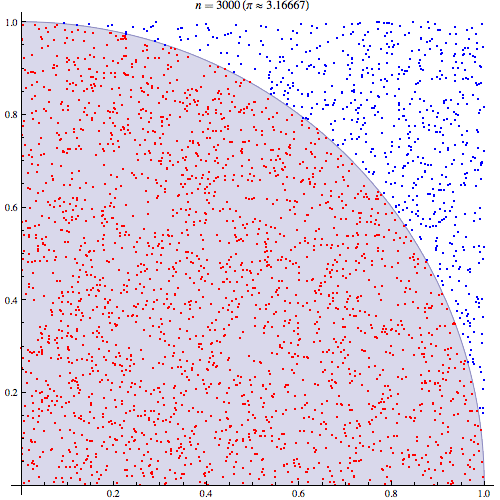

In [7]:
import random
def inside(p):
    return random.random()**2 + random.random()**2 < 1

In [8]:
NUM = 1000000
cnt = sc.parallelize(range(NUM)).filter(inside).count()
cnt*4.0/NUM

3.141312

**_Repartitioning_**

In [16]:
NUM_PARTITIONS = 4

In [17]:
t1 = time.time()
inside_count = sc.parallelize(range(10000000), NUM_PARTITIONS).filter(inside).count()
round(time.time() - t1, 2)

2.12

**How to tune?**
 * Too few partitions – Cannot utilize all cores available in the cluster.
 * Too many partitions – Excessive overhead in managing many small tasks.
 
1 task processes 1 partition

### **`glom`**: From partition to rows

In [10]:
ls = range(int(1e6))
ls_rdd = sc.parallelize(ls)

In [12]:
ls_rdd.reduce(max)

999999

In [13]:
ls_rdd.glom().map(max).reduce(max)

999999

`glom` can be helpful for matrix multiplications

### Distinct Names

**Problem**: Find number of distinct names per _first letter_

In [74]:
names = sc.textFile('/Users/300041370/data/names.txt')

In [77]:
names.sample(False, 5)

PythonRDD[76] at RDD at PythonRDD.scala:49

In [286]:
names.takeSample(False, 10)

['Nanete',
 'Afton',
 'Kiele',
 'Gabriella',
 'Jenn',
 'Madalena',
 'Andriana',
 'Sharlene',
 'Rafa',
 'Alayne']

In [270]:
names.map(lambda name: (name[0], name)).groupByKey().mapValues(lambda names: len(set(names))).take(3)

788.6038429737091


In [269]:
names.distinct().map(lambda name: name[0]).countByValue()

1500.3807621002197


### Puzzle

Find **_mutual friends_** given an adjacency list of friends

In [78]:
friends = ['ABCD', 'BACDE', 'CABDE', 'DABCE', 'EBCD']

In [79]:
friends_graph = [(list(f)[0], list(f)[1:]) for f in friends]

In [80]:
friends_graph

[('A', ['B', 'C', 'D']),
 ('B', ['A', 'C', 'D', 'E']),
 ('C', ['A', 'B', 'D', 'E']),
 ('D', ['A', 'B', 'C', 'E']),
 ('E', ['B', 'C', 'D'])]

In [81]:
friends_rdd = sc.parallelize(friends_graph)

In [82]:
friends_rdd.map(lambda x: [(x[0], l) for l in x[1]])

PythonRDD[78] at RDD at PythonRDD.scala:49

In [83]:
friends_rdd.map(lambda x: [((x[0], l), list(set(x[1]) - {l})) for l in x[1]])

PythonRDD[79] at RDD at PythonRDD.scala:49

In [84]:
friends_rdd.flatMap(lambda x: [((x[0], l), list(set(x[1]) - {l})) for l in x[1]])

PythonRDD[80] at RDD at PythonRDD.scala:49

In [85]:
friends_rdd.flatMap(lambda x: [(sorted((x[0], l)), list(set(x[1]) - {l})) for l in x[1]])

PythonRDD[81] at RDD at PythonRDD.scala:49

In [86]:
pair_friends = friends_rdd.flatMap(lambda x: [(sorted((x[0], l)), list(set(x[1]) - {l})) for l in x[1]])

In [40]:
pair_friends.reduceByKey(lambda x, y: set(x) & set(y)).collect() # gives error; what's the issue?

[unhashable type: 'list'](https://docs.python.org/3/tutorial/datastructures.html#dictionaries)

In [88]:
pair_friends = friends_rdd.flatMap(lambda x: [(tuple(sorted((x[0], l))), list(set(x[1]) - {l})) for l in x[1]])

In [89]:
pair_friends.collect()

[(('A', 'B'), ['C', 'D']),
 (('A', 'C'), ['B', 'D']),
 (('A', 'D'), ['B', 'C']),
 (('A', 'B'), ['C', 'D', 'E']),
 (('B', 'C'), ['D', 'A', 'E']),
 (('B', 'D'), ['C', 'A', 'E']),
 (('B', 'E'), ['C', 'A', 'D']),
 (('A', 'C'), ['B', 'D', 'E']),
 (('B', 'C'), ['D', 'A', 'E']),
 (('C', 'D'), ['B', 'A', 'E']),
 (('C', 'E'), ['B', 'A', 'D']),
 (('A', 'D'), ['B', 'C', 'E']),
 (('B', 'D'), ['C', 'A', 'E']),
 (('C', 'D'), ['B', 'A', 'E']),
 (('D', 'E'), ['B', 'C', 'A']),
 (('B', 'E'), ['C', 'D']),
 (('C', 'E'), ['B', 'D']),
 (('D', 'E'), ['B', 'C'])]

In [90]:
pair_friends.reduceByKey(lambda x, y: set(x) & set(y)).collect()

[(('A', 'B'), {'C', 'D'}),
 (('B', 'C'), {'A', 'D', 'E'}),
 (('C', 'D'), {'A', 'B', 'E'}),
 (('C', 'E'), {'B', 'D'}),
 (('A', 'D'), {'B', 'C'}),
 (('D', 'E'), {'B', 'C'}),
 (('A', 'C'), {'B', 'D'}),
 (('B', 'D'), {'A', 'C', 'E'}),
 (('B', 'E'), {'C', 'D'})]

## Discussion
 
1. How to do a query-level analysis on ustream & ustream_non_logged_in? `union`
2. Filter out only listEvents from ustream and create a listEvents_ustream? `saveAsTextFile`
3. _Distributed Shared Variables_: Accumulators (MapReduce's Counter) & Broadcast variables (config)
4. Compute intensive: Checkpoint RDD (write to an external filesystem)
5. How to dump an RDD into a database?
6. How to find stages from DAG?

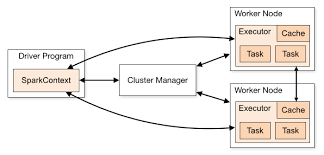

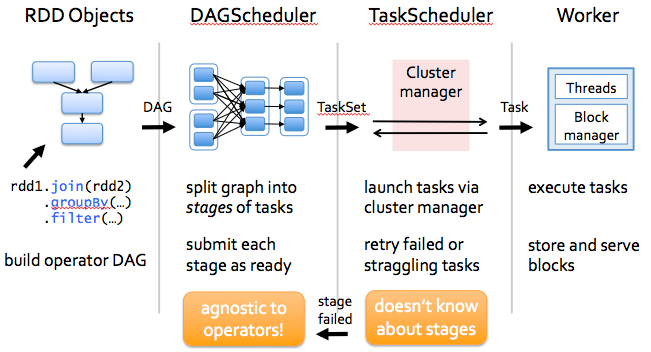

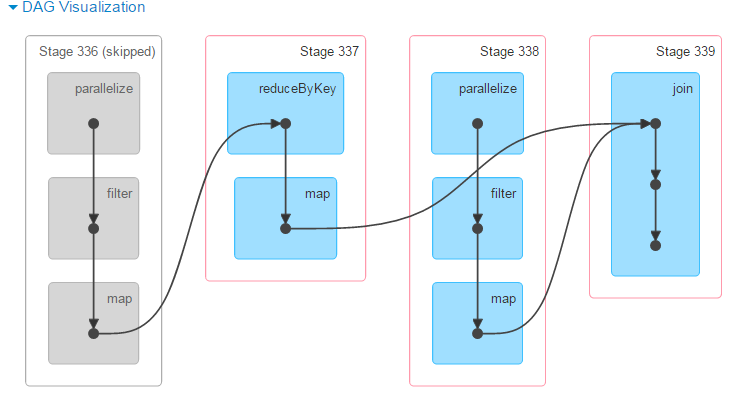

## Spark DataFrame

In [80]:
df = spark.read.json('/Users/300041370/data/people.json')

In [81]:
df.show()

+----+-------+
| age|   name|
+----+-------+
|null|Michael|
|  30|   Andy|
|  19| Justin|
+----+-------+



In [82]:
df.printSchema()

root
 |-- age: long (nullable = true)
 |-- name: string (nullable = true)



In [83]:
df.columns

['age', 'name']

In [84]:
df.describe()

DataFrame[summary: string, age: string, name: string]

In [85]:
df.describe().show()

+-------+------------------+-------+
|summary|               age|   name|
+-------+------------------+-------+
|  count|                 2|      3|
|   mean|              24.5|   null|
| stddev|7.7781745930520225|   null|
|    min|                19|   Andy|
|    max|                30|Michael|
+-------+------------------+-------+



In [86]:
df.select('age').show()

+----+
| age|
+----+
|null|
|  30|
|  19|
+----+



In [87]:
df.head(2)

[Row(age=None, name='Michael'), Row(age=30, name='Andy')]

#### Spark SQL

In [88]:
df.createOrReplaceTempView('people')

In [89]:
spark.sql('SELECT * FROM people WHERE age=30').show()

+---+----+
|age|name|
+---+----+
| 30|Andy|
+---+----+



### Wordcount in dataframe

In [99]:
tales_df = spark.read.text('/Users/300041370/data/shakespeare_tales.txt')

In [110]:
tales_words = tales_df.select(F.explode(F.split(tales_df['value'], ' ')).alias('word'))

In [170]:
tales_words.groupBy(tales_words['word']).count().orderBy('count', ascending=False).show(5)

+----+-----+
|word|count|
+----+-----+
| the| 4960|
| and| 3774|
|  to| 3577|
|  of| 2983|
|    | 2609|
+----+-----+
only showing top 5 rows



In [169]:
tales_words.where(tales_words['word'].isin(['could', 'would', 'should']))\
            .groupBy(tales_words['word'])\
            .count().show()

+------+-----+
|  word|count|
+------+-----+
| could|  225|
|should|  249|
| would|  431|
+------+-----+



[`where` is an alias for `filter`](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.filter)

### Apple Stock prices

In [118]:
app = spark.read.csv('/Users/300041370/data/apple_stock.csv', inferSchema=True, header=True)

In [119]:
app.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Adj Close: double (nullable = true)



In [120]:
app.show(5)

+-------------------+----------+----------+------------------+------------------+---------+------------------+
|               Date|      Open|      High|               Low|             Close|   Volume|         Adj Close|
+-------------------+----------+----------+------------------+------------------+---------+------------------+
|2010-01-04 00:00:00|213.429998|214.499996|212.38000099999996|        214.009998|123432400|         27.727039|
|2010-01-05 00:00:00|214.599998|215.589994|        213.249994|        214.379993|150476200|27.774976000000002|
|2010-01-06 00:00:00|214.379993|    215.23|        210.750004|        210.969995|138040000|27.333178000000004|
|2010-01-07 00:00:00|    211.75|212.000006|        209.050005|            210.58|119282800|          27.28265|
|2010-01-08 00:00:00|210.299994|212.000006|209.06000500000002|211.98000499999998|111902700|         27.464034|
+-------------------+----------+----------+------------------+------------------+---------+------------------+
o

In [175]:
app.withColumn('Delta', app['Close'] - app['Open']).select('High', 'Low', 'Close', 'Open', 'Delta').show(5)

+----------+------------------+------------------+----------+--------------------+
|      High|               Low|             Close|      Open|               Delta|
+----------+------------------+------------------+----------+--------------------+
|214.499996|212.38000099999996|        214.009998|213.429998|  0.5799999999999841|
|215.589994|        213.249994|        214.379993|214.599998|-0.22000499999998624|
|    215.23|        210.750004|        210.969995|214.379993| -3.4099980000000016|
|212.000006|        209.050005|            210.58|    211.75| -1.1699999999999875|
|212.000006|209.06000500000002|211.98000499999998|210.299994|   1.680010999999979|
+----------+------------------+------------------+----------+--------------------+
only showing top 5 rows



In [176]:
app.filter(app['Close'] < 92).select('Open', 'Close').show(5)

+---------+-----------------+
|     Open|            Close|
+---------+-----------------+
|92.199997|        91.279999|
|92.290001|        91.860001|
|91.849998|        90.910004|
|    91.32|90.83000200000001|
|    90.75|        90.279999|
+---------+-----------------+
only showing top 5 rows



In [177]:
app.filter('Close < 92').select('Open', 'Close').show(5)

+---------+-----------------+
|     Open|            Close|
+---------+-----------------+
|92.199997|        91.279999|
|92.290001|        91.860001|
|91.849998|        90.910004|
|    91.32|90.83000200000001|
|    90.75|        90.279999|
+---------+-----------------+
only showing top 5 rows



In [72]:
app.filter((app['Close'] < 200) & (app['Open'] > 200)).show()

+-------------------+------------------+----------+----------+----------+---------+------------------+
|               Date|              Open|      High|       Low|     Close|   Volume|         Adj Close|
+-------------------+------------------+----------+----------+----------+---------+------------------+
|2010-01-22 00:00:00|206.78000600000001|207.499996|    197.16|    197.75|220441900|         25.620401|
|2010-01-28 00:00:00|        204.930004|205.500004|198.699995|199.289995|293375600|25.819922000000002|
|2010-01-29 00:00:00|        201.079996|202.199995|190.250002|192.060003|311488100|         24.883208|
+-------------------+------------------+----------+----------+----------+---------+------------------+



In [156]:
app.select(F.round(app['Low'], 2).alias('Low'), F.round(app['High'], 2).alias('High')).show(5)

+------+------+
|   Low|  High|
+------+------+
|212.38| 214.5|
|213.25|215.59|
|210.75|215.23|
|209.05| 212.0|
|209.06| 212.0|
+------+------+
only showing top 5 rows



In [151]:
app.filter(app['Low'] == 197.16).show()

+-------------------+------------------+----------+------+------+---------+---------+
|               Date|              Open|      High|   Low| Close|   Volume|Adj Close|
+-------------------+------------------+----------+------+------+---------+---------+
|2010-01-22 00:00:00|206.78000600000001|207.499996|197.16|197.75|220441900|25.620401|
+-------------------+------------------+----------+------+------+---------+---------+



### CheatSheets

 * [DataCamp](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/PySpark_SQL_Cheat_Sheet_Python.pdf)
 * [Qubole](https://www.qubole.com/resources/pyspark-cheatsheet/)

## Madlytics

In [26]:
madlytics = spark.read.orc('/Users/300041370/data/sample_madlytics.zlib.orc')

In [41]:
madlytics.show(2)

In [42]:
madlytics.columns

In [183]:
madlytics.printSchema()

root
 |-- server_ts: string (nullable = true)
 |-- app_name: string (nullable = true)
 |-- app_build: string (nullable = true)
 |-- app_version: string (nullable = true)
 |-- ab_tests: string (nullable = true)
 |-- device_build_number: string (nullable = true)
 |-- device_id: string (nullable = true)
 |-- device_height: string (nullable = true)
 |-- device_imei: string (nullable = true)
 |-- installation_id: string (nullable = true)
 |-- device_manufacturer: string (nullable = true)
 |-- device_model_number: string (nullable = true)
 |-- os_api_version: string (nullable = true)
 |-- bluetooth: string (nullable = true)
 |-- nfc: string (nullable = true)
 |-- geo_lat: string (nullable = true)
 |-- geo_long: string (nullable = true)
 |-- state: string (nullable = true)
 |-- country: string (nullable = true)
 |-- network_carrier: string (nullable = true)
 |-- network_ip: string (nullable = true)
 |-- network_type: string (nullable = true)
 |-- session_auto_id: string (nullable = true)
 |--

In [51]:
pandas_dataframe = madlytics.filter('mrp > 1000').select(['device_manufacturer', 'event_type']).toPandas()

In [184]:
madlytics.select('notification_class').distinct().show()

+------------------+
|notification_class|
+------------------+
|         MARKETING|
|     TRANSACTIONAL|
|             SALES|
|       REMARKETING|
|                  |
+------------------+



In [16]:
madlytics.groupBy('device_manufacturer').count().orderBy('count', ascending=False).show()

+-------------------+-----+
|device_manufacturer|count|
+-------------------+-----+
|             Xiaomi|25931|
|            samsung|18978|
|              Apple|14376|
|               vivo| 8482|
|               OPPO| 8217|
|            OnePlus| 7026|
|                   | 6699|
|           motorola| 5647|
|             HUAWEI| 4109|
|               asus| 1677|
|         HMD Global| 1664|
|             LENOVO| 1598|
|             Realme|  567|
|             GIONEE|  443|
|             Google|  441|
|               Sony|  313|
|           Micromax|  292|
|             lenovo|  262|
|                LGE|  255|
|                HTC|  249|
+-------------------+-----+
only showing top 20 rows



In [43]:
device_counts = madlytics.groupBy('device_manufacturer').count().orderBy('count', ascending=False)
device_counts.explain(True)

== Parsed Logical Plan ==
'Sort ['count DESC NULLS LAST], true
+- AnalysisBarrier
      +- Aggregate [device_manufacturer#10], [device_manufacturer#10, count(1) AS count#1477L]
         +- Relation[server_ts#0,app_name#1,app_build#2,app_version#3,ab_tests#4,device_build_number#5,device_id#6,device_height#7,device_imei#8,installation_id#9,device_manufacturer#10,device_model_number#11,os_api_version#12,bluetooth#13,nfc#14,geo_lat#15,geo_long#16,state#17,country#18,network_carrier#19,network_ip#20,network_type#21,session_auto_id#22,session_previous_screen#23,... 108 more fields] orc

== Analyzed Logical Plan ==
device_manufacturer: string, count: bigint
Sort [count#1477L DESC NULLS LAST], true
+- Aggregate [device_manufacturer#10], [device_manufacturer#10, count(1) AS count#1477L]
   +- Relation[server_ts#0,app_name#1,app_build#2,app_version#3,ab_tests#4,device_build_number#5,device_id#6,device_height#7,device_imei#8,installation_id#9,device_manufacturer#10,device_model_number#11,os_api_v

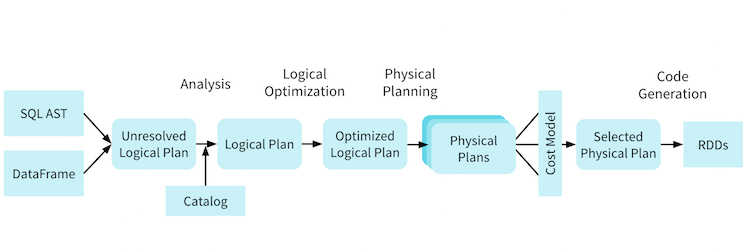

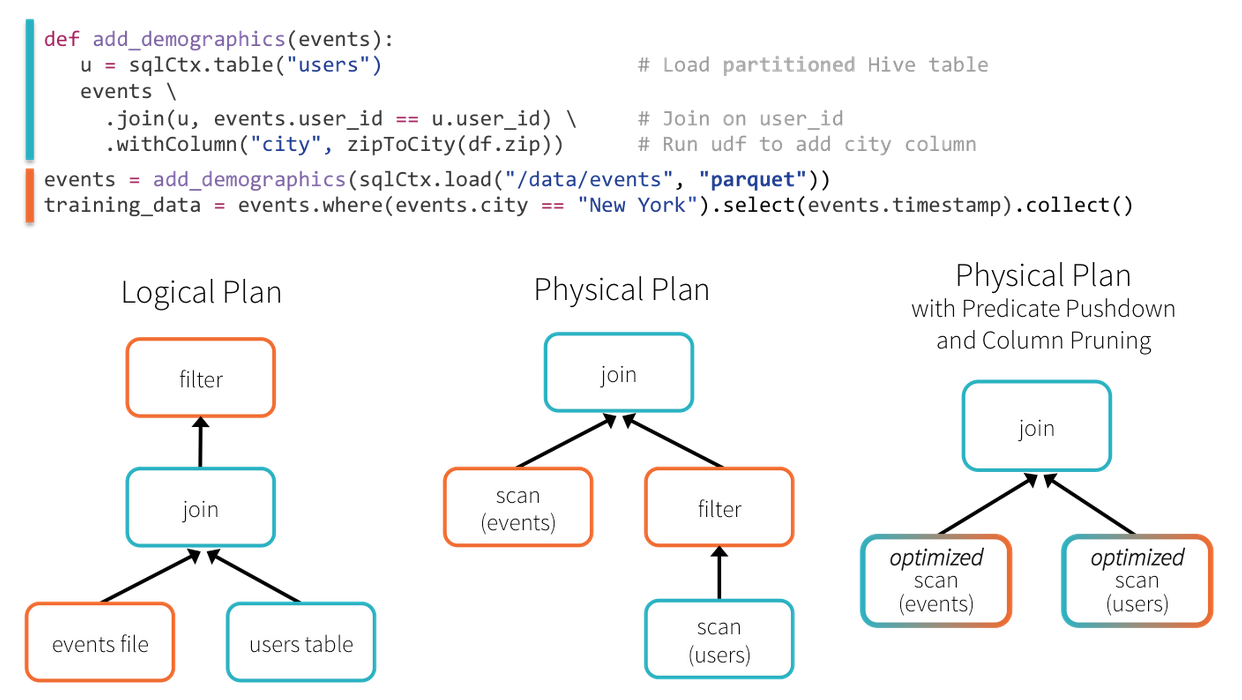

* **Logical Plan**: _dataflow_
* **Physical Plan**: _execution flow_

In [106]:
madlytics.groupBy('event_type').count().show()

+--------------------+-----+
|          event_type|count|
+--------------------+-----+
|     Dismiss Filters|    6|
|Reviews Image - R...|    1|
|Order Confirmatio...|   10|
|  banner-child-click|  519|
|Cart Page - Empty...|   46|
|Share Intent Invoked|    9|
|JuspayTransaction...|    1|
|           CacheSize|  791|
|   SearchFired_brand|    3|
|QR code - QR_scre...|    2|
|StylePlus - FAQ W...|    6|
|           CrossLink|   50|
|       ProfileLogout|    6|
|StylePlus - Histo...|    1|
|    myOrdersTryLooks|   10|
|  FilterOptionSelect|  360|
|    PDPComponentLoad|43534|
|Payment Page - pa...|   42|
|visual-search-ini...|    4|
|Clk_Homepage_Cart...|    1|
+--------------------+-----+
only showing top 20 rows



In [ ]:
madlytics.createOrReplaceTempView('madlytics')

In [42]:
spark.sql("SELECT DISTINCT event_type FROM madlytics WHERE mrp > 500").show()

+--------------------+
|          event_type|
+--------------------+
|          widgetLoad|
|broken size butto...|
| broken size clicked|
|          ImageSwipe|
|       clickForOffer|
|           ImageZoom|
|          sizeSelect|
+--------------------+



### Another DataFrame Example

In [126]:
sales = spark.read.csv('/Users/300041370/data/sales_info.csv', inferSchema=True, header=True)

In [127]:
sales.show()

+-------+-------+-----+
|Company| Person|Sales|
+-------+-------+-----+
|   GOOG|    Sam|200.0|
|   GOOG|Charlie|120.0|
|   GOOG|  Frank|340.0|
|   MSFT|   Tina|600.0|
|   MSFT|    Amy|124.0|
|   MSFT|Vanessa|243.0|
|     FB|   Carl|870.0|
|     FB|  Sarah|350.0|
|   APPL|   John|250.0|
|   APPL|  Linda|130.0|
|   APPL|   Mike|750.0|
|   APPL|  Chris|350.0|
+-------+-------+-----+



In [128]:
sales.printSchema()

root
 |-- Company: string (nullable = true)
 |-- Person: string (nullable = true)
 |-- Sales: double (nullable = true)



In [132]:
sales.groupBy('Company').mean().show()

+-------+-----------------+
|Company|       avg(Sales)|
+-------+-----------------+
|   APPL|            370.0|
|   GOOG|            220.0|
|     FB|            610.0|
|   MSFT|322.3333333333333|
+-------+-----------------+



In [134]:
sales.groupBy('Company').count().show()

+-------+-----+
|Company|count|
+-------+-----+
|   APPL|    4|
|   GOOG|    3|
|     FB|    2|
|   MSFT|    3|
+-------+-----+



In [135]:
sales.groupBy('Company').agg({'Sales': 'max'}).show()

+-------+----------+
|Company|max(Sales)|
+-------+----------+
|   APPL|     750.0|
|   GOOG|     340.0|
|     FB|     870.0|
|   MSFT|     600.0|
+-------+----------+



In [138]:
from pyspark.sql.functions import countDistinct, avg, stddev, format_number

In [137]:
sales.select(countDistinct('Sales')).show()

+---------------------+
|count(DISTINCT Sales)|
+---------------------+
|                   11|
+---------------------+



In [139]:
sales.select(stddev('Sales').alias('std')).select(format_number('std', 2)).show()

+---------------------+
|format_number(std, 2)|
+---------------------+
|               250.09|
+---------------------+



In [140]:
sales.orderBy('Sales').show()

+-------+-------+-----+
|Company| Person|Sales|
+-------+-------+-----+
|   GOOG|Charlie|120.0|
|   MSFT|    Amy|124.0|
|   APPL|  Linda|130.0|
|   GOOG|    Sam|200.0|
|   MSFT|Vanessa|243.0|
|   APPL|   John|250.0|
|   GOOG|  Frank|340.0|
|     FB|  Sarah|350.0|
|   APPL|  Chris|350.0|
|   MSFT|   Tina|600.0|
|   APPL|   Mike|750.0|
|     FB|   Carl|870.0|
+-------+-------+-----+



## Spark ML

#### Spark MLlib is built on DataFrames. It's a fusion of sklearn & DataFrame. Similar to sklearn, it too has Transformers, Estimators and Pipelines.

 * **Transformer**: Transforms one DataFrame into another, e.g. StringIndexer
 * **Estimator**: A learning algorithm, e.g. LogisticRegression.
 * **Pipeline**: Chains multiple transformers with a final estimator.

### Spark Inspiration
 * _Computation_: MapReduce. Computation near data. Coarse-grained transformations
 * _Data Wrangling_: Pandas. DataFrame manipulation & aggregation.
 * _ML_: Scikit-learn. Transformer, Estimator, Pipeline.

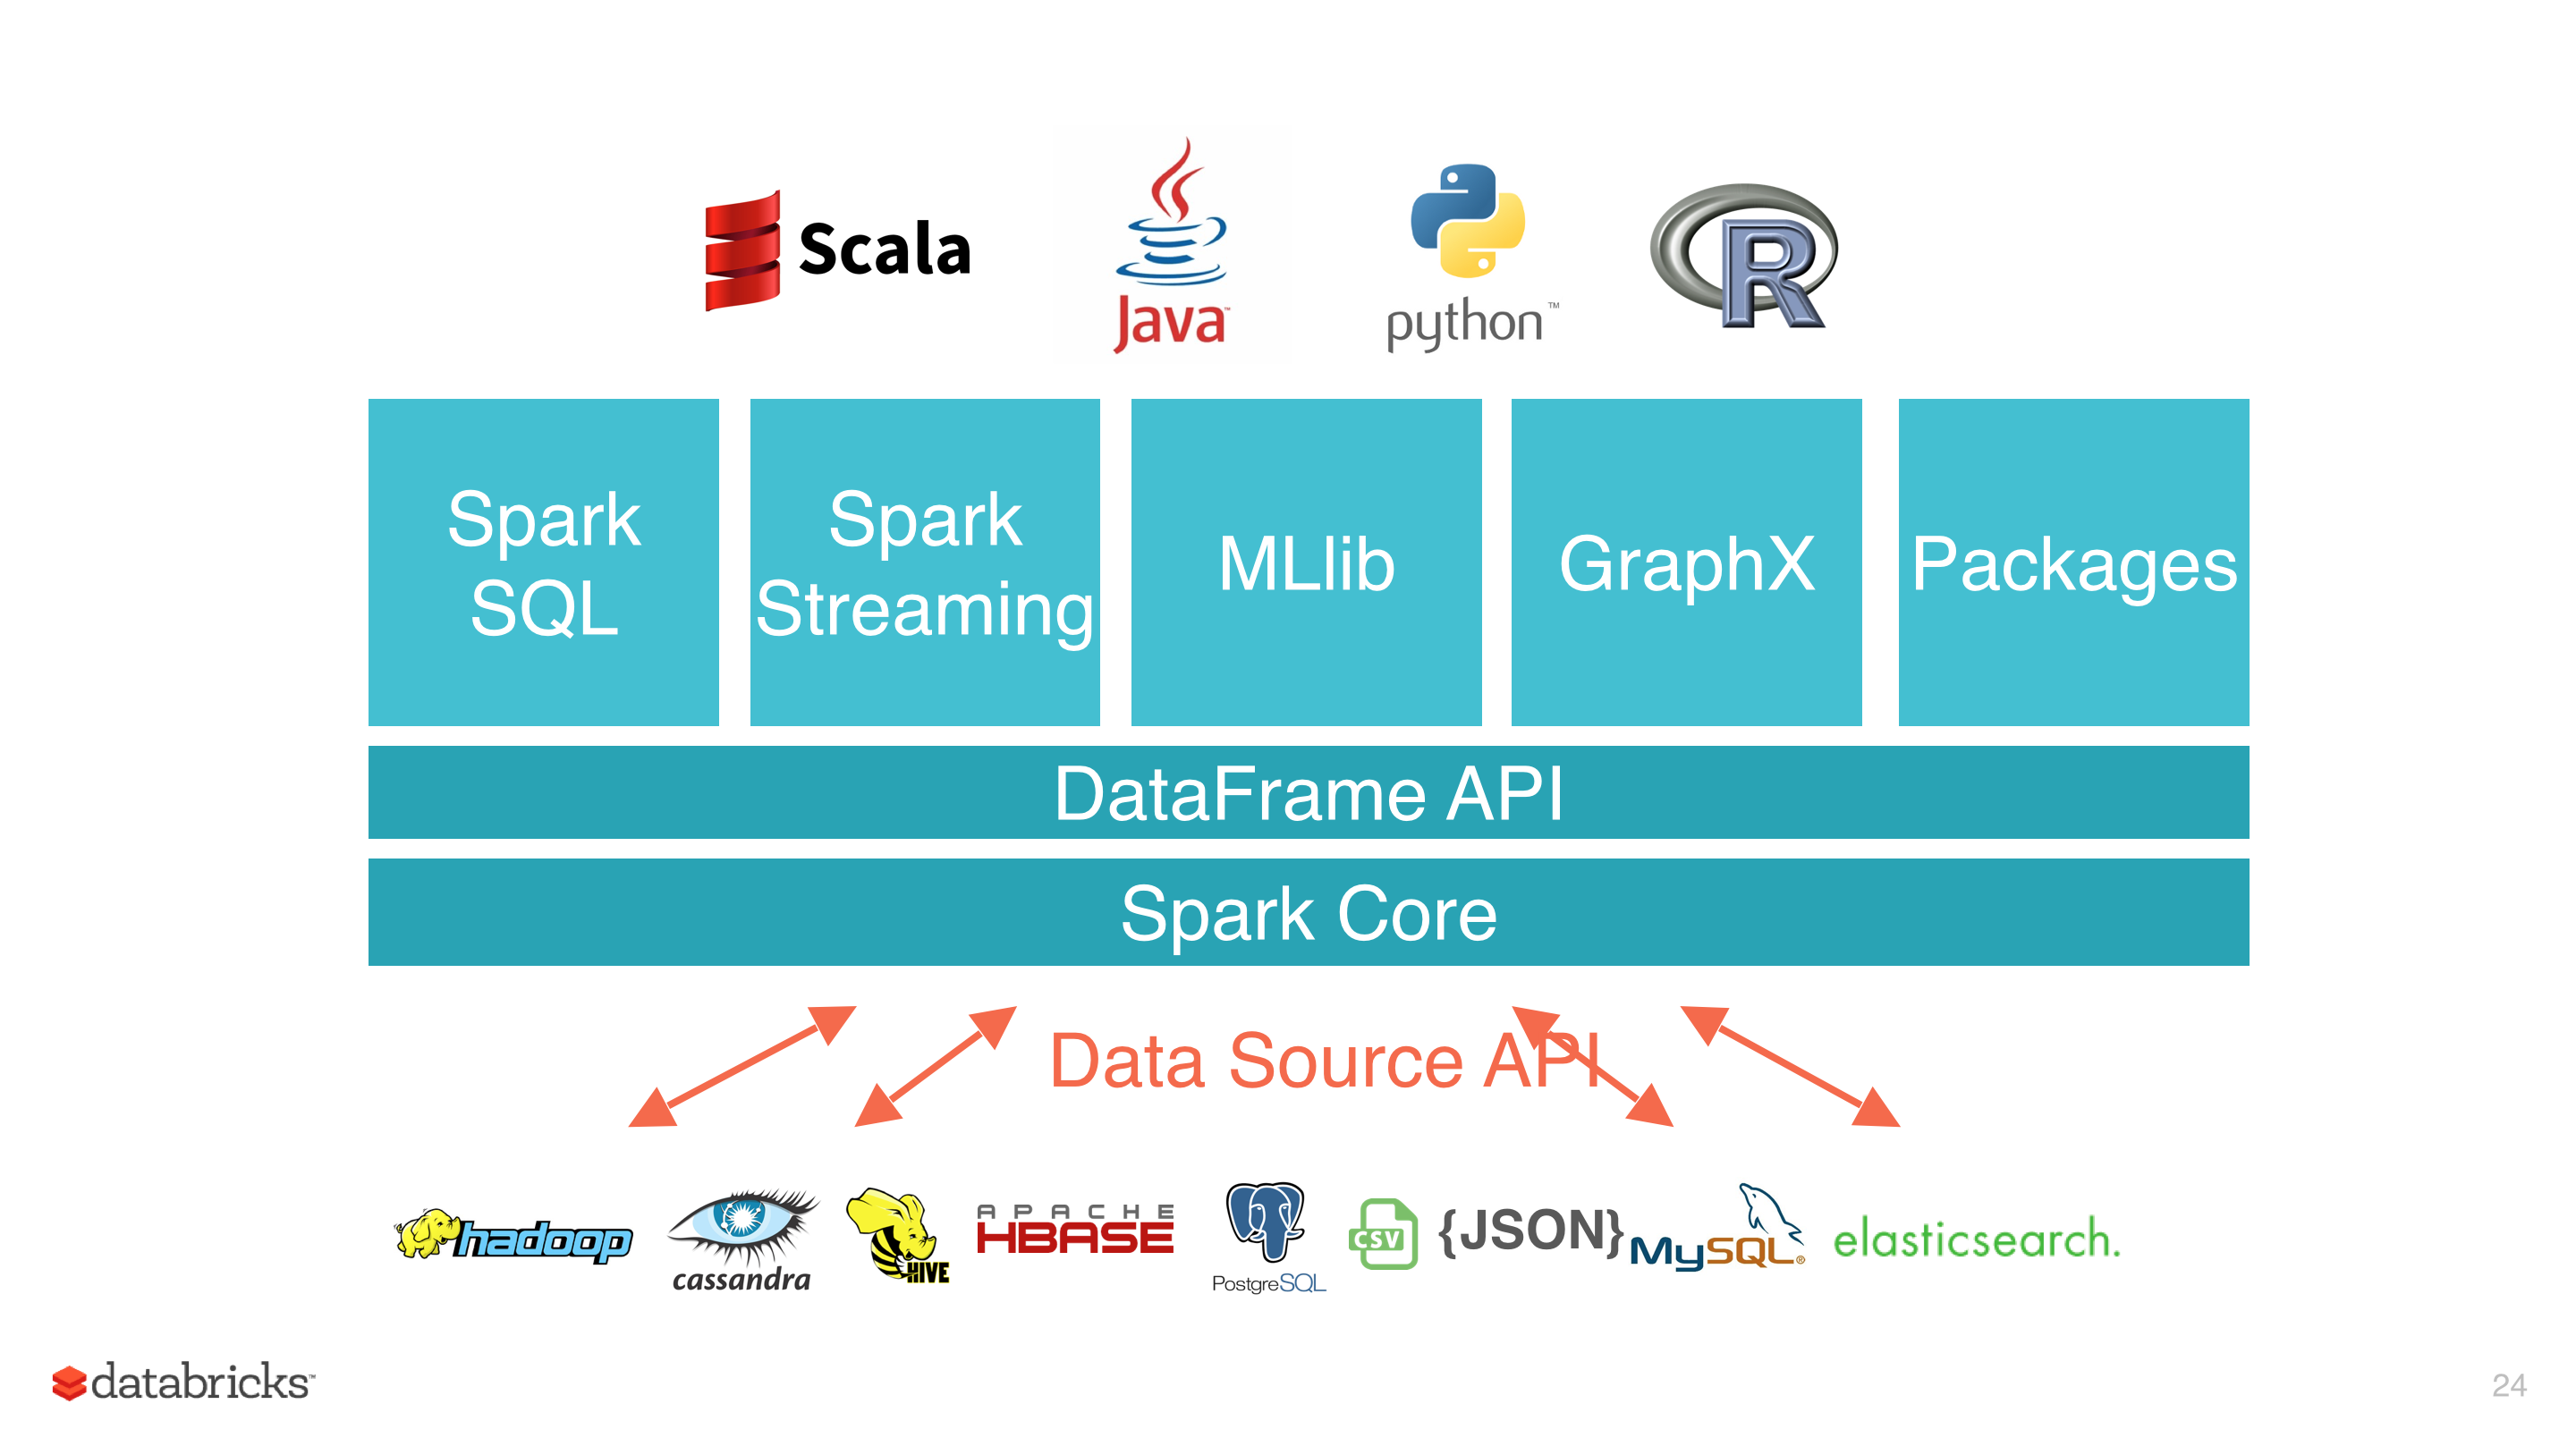

### Decision Trees

In [62]:
college = spark.read.csv('/Users/300041370/data/college.csv', inferSchema=True, header=True)

In [63]:
college.printSchema()

root
 |-- School: string (nullable = true)
 |-- Private: string (nullable = true)
 |-- Apps: integer (nullable = true)
 |-- Accept: integer (nullable = true)
 |-- Enroll: integer (nullable = true)
 |-- Top10perc: integer (nullable = true)
 |-- Top25perc: integer (nullable = true)
 |-- F_Undergrad: integer (nullable = true)
 |-- P_Undergrad: integer (nullable = true)
 |-- Outstate: integer (nullable = true)
 |-- Room_Board: integer (nullable = true)
 |-- Books: integer (nullable = true)
 |-- Personal: integer (nullable = true)
 |-- PhD: integer (nullable = true)
 |-- Terminal: integer (nullable = true)
 |-- S_F_Ratio: double (nullable = true)
 |-- perc_alumni: integer (nullable = true)
 |-- Expend: integer (nullable = true)
 |-- Grad_Rate: integer (nullable = true)



In [64]:
college.head(1)

[Row(School='Abilene Christian University', Private='Yes', Apps=1660, Accept=1232, Enroll=721, Top10perc=23, Top25perc=52, F_Undergrad=2885, P_Undergrad=537, Outstate=7440, Room_Board=3300, Books=450, Personal=2200, PhD=70, Terminal=78, S_F_Ratio=18.1, perc_alumni=12, Expend=7041, Grad_Rate=60)]

In [65]:
college.show(3)

+--------------------+-------+----+------+------+---------+---------+-----------+-----------+--------+----------+-----+--------+---+--------+---------+-----------+------+---------+
|              School|Private|Apps|Accept|Enroll|Top10perc|Top25perc|F_Undergrad|P_Undergrad|Outstate|Room_Board|Books|Personal|PhD|Terminal|S_F_Ratio|perc_alumni|Expend|Grad_Rate|
+--------------------+-------+----+------+------+---------+---------+-----------+-----------+--------+----------+-----+--------+---+--------+---------+-----------+------+---------+
|Abilene Christian...|    Yes|1660|  1232|   721|       23|       52|       2885|        537|    7440|      3300|  450|    2200| 70|      78|     18.1|         12|  7041|       60|
|  Adelphi University|    Yes|2186|  1924|   512|       16|       29|       2683|       1227|   12280|      6450|  750|    1500| 29|      30|     12.2|         16| 10527|       56|
|      Adrian College|    Yes|1428|  1097|   336|       22|       50|       1036|         99|  

In [66]:
college.columns

['School',
 'Private',
 'Apps',
 'Accept',
 'Enroll',
 'Top10perc',
 'Top25perc',
 'F_Undergrad',
 'P_Undergrad',
 'Outstate',
 'Room_Board',
 'Books',
 'Personal',
 'PhD',
 'Terminal',
 'S_F_Ratio',
 'perc_alumni',
 'Expend',
 'Grad_Rate']

In [67]:
from pyspark.ml.feature import VectorAssembler

In [68]:
assembler = VectorAssembler(inputCols=['Apps', 'Accept', 'Enroll', 'Top10perc', 
                                       'Top25perc', 'F_Undergrad', 'P_Undergrad', 'Outstate', 
                                       'Room_Board', 'Books', 'Personal', 'PhD', 'Terminal', 
                                       'S_F_Ratio', 'perc_alumni', 'Expend', 'Grad_Rate'], 
                            outputCol='features')

In [69]:
output = assembler.transform(college)

In [70]:
set(output.columns) - set(college.columns)

{'features'}

In [71]:
output.select('features').show(3)

+--------------------+
|            features|
+--------------------+
|[1660.0,1232.0,72...|
|[2186.0,1924.0,51...|
|[1428.0,1097.0,33...|
+--------------------+
only showing top 3 rows



In [72]:
from pyspark.ml.feature import StringIndexer

In [73]:
indexer = StringIndexer(inputCol='Private', outputCol='PrivateIndex')

In [74]:
output_fixed = indexer.fit(output).transform(output)

In [75]:
output_fixed.head(1)

[Row(School='Abilene Christian University', Private='Yes', Apps=1660, Accept=1232, Enroll=721, Top10perc=23, Top25perc=52, F_Undergrad=2885, P_Undergrad=537, Outstate=7440, Room_Board=3300, Books=450, Personal=2200, PhD=70, Terminal=78, S_F_Ratio=18.1, perc_alumni=12, Expend=7041, Grad_Rate=60, features=DenseVector([1660.0, 1232.0, 721.0, 23.0, 52.0, 2885.0, 537.0, 7440.0, 3300.0, 450.0, 2200.0, 70.0, 78.0, 18.1, 12.0, 7041.0, 60.0]), PrivateIndex=0.0)]

In [76]:
final_data = output_fixed.select('features', 'PrivateIndex')

In [77]:
final_data.show(3)

+--------------------+------------+
|            features|PrivateIndex|
+--------------------+------------+
|[1660.0,1232.0,72...|         0.0|
|[2186.0,1924.0,51...|         0.0|
|[1428.0,1097.0,33...|         0.0|
+--------------------+------------+
only showing top 3 rows



In [78]:
train_data, test_data = final_data.randomSplit([0.7, 0.3])

In [79]:
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier, RandomForestClassifier

In [80]:
from pyspark.ml.regression import RandomForestRegressor

In [81]:
dtc = DecisionTreeClassifier(labelCol='PrivateIndex', featuresCol='features')
rfc = RandomForestClassifier(labelCol='PrivateIndex', featuresCol='features')
gbt = GBTClassifier(labelCol='PrivateIndex', featuresCol='features')

In [83]:
dtc_model = dtc.fit(train_data)
rfc_model = rfc.fit(train_data)
gbt_model = gbt.fit(train_data)

In [84]:
dtc_preds = dtc_model.transform(test_data)
rfc_preds = rfc_model.transform(test_data)
gbt_preds = gbt_model.transform(test_data)

In [85]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [87]:
binary_eval = BinaryClassificationEvaluator(labelCol='PrivateIndex')

In [89]:
binary_eval.evaluate(dtc_preds), binary_eval.evaluate(rfc_preds), binary_eval.evaluate(gbt_preds)

(0.9525935374149661, 0.988095238095238, 0.98171768707483)

#### Fraud Detection

In [194]:
paysim = spark.read.csv('/Users/300041370/data/paysim_small.csv', header=True, inferSchema=True)

In [195]:
paysim.printSchema()

root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)



In [196]:
paysim.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|      

In [199]:
train, test = paysim.randomSplit([0.8, 0.2])

In [200]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier

In [201]:
indexer = StringIndexer(inputCol='type', outputCol='typeIdx')
va = VectorAssembler(inputCols=['typeIdx', 'amount', 'oldbalanceOrg', 
                                 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'], outputCol='features')
dt = DecisionTreeClassifier(labelCol='isFraud', featuresCol='features', maxDepth=5)
pipeline = Pipeline(stages=[indexer, va, dt])

In [202]:
dt_model = pipeline.fit(train)

In [203]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [205]:
paramGrid = ParamGridBuilder() \
            .addGrid(dt.maxDepth, [5, 10, 15]) \
            .addGrid(dt.maxBins, [10, 20, 30]) \
            .build()

crossval = CrossValidator(estimator=dt,
                         estimatorParamMaps=paramGrid,
                         evaluator=BinaryClassificationEvaluator(),
                         numFolds=3)

pipelineCV = Pipeline(stages=[indexer, va, crossval])

In [207]:
# cvModel = pipelineCV.fit(train)

In [209]:
# train_pred_b = cvModel_b.transform(train_b)
# test_pred = cvModel.transform(test)

In [210]:
# BinaryClassificationEvaluator.evaluate

### Performance Advice

1. Use `reduceBy` operations instead of `groupBy` if aggregation is commutative and associative.
2. [Remember to set flags](https://spark.apache.org/docs/latest/configuration.html) like `spark.driver.maxResultSize`, `spark.executor.memory` in EMR config to get optimal performance
3. Appropriate data format: Binary format takes less space and enforces typing. If data is columnar, _Parquet_ format is preferable.

#### Flags and Properties

 * `spark.driver.maxResultSize`: when you need to `collect` huge amount of data
 * `org.apache.hadoop.yarn.util.resource.DefaultResourceCalculator`: to allocate appropriate vcores and RAM
 * `--executor-cores`: around 5 is optimal

## Spark Streaming

In [15]:
lines = spark.readStream\
        .format('socket')\
        .option('host', 'localhost')\
        .option('port', 9999)\
        .load()

In [23]:
words = lines.select(
            F.explode(
                F.split(lines.value, ' ')
            ).alias('word')
        )

In [24]:
wordCounts = words.groupBy('word').count()

In [27]:
query = wordCounts.writeStream.outputMode('complete').format('console').start()
query.awaitTermination()

In [ ]:
query.stop()

[EMR Console](https://ap-southeast-1.console.aws.amazon.com/elasticmapreduce/home?region=ap-southeast-1)

Command to create an AWS EMR cluster,

```aws emr create-cluster --name 'EMR test' --ec2-attributes KeyName=datascience-adhoc,AvailabilityZone=ap-southeast-1a --release-label emr-5.22.0 --applications Name=Spark --instance-groups InstanceGroupType=MASTER,InstanceCount=1,InstanceType=m4.large InstanceGroupType=CORE,InstanceCount=1,InstanceType=m4.large --use-default-roles```

this returns a _ClusterId_ like "j-33BGK7M3S030C"

To ssh to this cluster,

```aws emr ssh --key-pair-file ~/credentials/datascience-adhoc.pem --cluster-id j-33BGK7M3S030C```

To terminate the cluster,

```aws emr terminate-clusters --cluster-ids j-33BGK7M3S030C```

### Resources
 * http://shop.oreilly.com/product/9780596510046.do
 * https://www.usenix.org/legacy/events/osdi04/tech/full_papers/dean/dean.pdf
 * http://web.stanford.edu/class/cs345d-01/rl/MRvsPDBMS.pdf
 * http://static.usenix.org/legacy/events/hotcloud10/tech/full_papers/Zaharia.pdf
 * https://www.usenix.org/system/files/conference/nsdi12/nsdi12-final138.pdf
 * [Spark SQL: Relational Data Processing in Spark](http://people.csail.mit.edu/matei/papers/2015/sigmod_spark_sql.pdf)
 * [Discretized Streams: Fault-Tolerant Streaming Computation at Scale](http://people.csail.mit.edu/matei/papers/2013/sosp_spark_streaming.pdf)

# Story

#### [_McIlroy vs Knuth_](http://www.leancrew.com/all-this/2011/12/more-shell-less-egg/) and word counts
Jon Bentley had a regular column called “Programming Pearls” in the _Communications of the ACM_. In 1986 he got interested in literate programming, so he asked Donald Knuth to write a program in that style as a guest column and Doug McIlroy to write a literary-style critique of it. The program was
> Read a file of text, determine the _n_ most frequently used words, and print out a sorted list of those words along with their frequencies.

Knuth's 10+ pages of Pascal program used a clever, purpose-built data structure for keeping track of the words and frequency counts.

Doug McIlroy replied with following script
```sh
tr -cs A-Za-z '\n' |
tr A-Z a-z |
sort |
uniq -c |
sort -rn |
sed ${1}q
```
___

McIlroy, the inventor of Unix pipes, said,
> We should have some ways of connecting programs like [a] garden hose—screw in another segment when it becomes necessary to massage data in another way. This is the way of I/O also.
The idea of connecting programs with pipes became known as the Unix philosophy
1. Make each program do one thing well. (Sort spills to disk and uses multiple threads)
2. Expect the output of every program to become the input to another, as yet unknown, program.

 - Using these niche programs, we can **_compose_** a powerful data processing job (loose coupling).\
 - To connect any program’s output to any program’s input, all programs must use the same IO interface and data format. 
 - In Unix, that interface is a file and format is ASCII (Separation of logic and wiring).\

**Pipe cons**:
 - Multiple I/O
 - Output to network connection
___